In [6]:

import os
import random
import numpy as np
import yfinance as yf
import torch.nn as nn
import pandas as pd
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.regression.linear_model import OLS
# import statsmodels.api as sm
from matplotlib import pyplot as plt
%matplotlib inline


In [7]:
class TF(nn.Module):
    def __init__(self, ticker, start_date, end_date, riskfree_rate=0.04):
        super(TF, self).__init__()
        self.ticker_list = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.riskfree_rate = riskfree_rate
        self.stock = self.get_stock_data()

    def get_stock_data(self):
        print("===== DOWNLOADING STOCK DATA =====")
        df = yf.download(self.ticker_list, start=self.start_date, end=self.end_date)['Adj Close']
        print("===== DOWNLOAD COMPLETE =====")

        return pd.DataFrame(df)

    def forward(self, alpha_1, alpha_2):
        # add sma columns
        stock_df = self.stock.copy()
        
        stock_df['EWM_'+str(alpha_1)] = stock_df['Adj Close'].ewm(alpha=alpha_1, adjust=False).mean()
        stock_df['EWM_'+str(alpha_2)] = stock_df['Adj Close'].ewm(alpha=alpha_2, adjust=False).mean()
        
        self.df_sma = stock_df
       
        # drop na
        stock_df.dropna(inplace=True)
        # log returns of the Buy and Hold strategy
        stock_df['log_return_buy_n_hold'] = np.log(stock_df['Adj Close'] / stock_df['Adj Close'].shift(1))
        # identify buy and sell signal
        stock_df['signal'] = np.where(stock_df['EWM_'+str(alpha_1)] > stock_df['EWM_'+str(alpha_2)], 1, 0)
        stock_df['signal'] = np.where(stock_df['EWM_'+str(alpha_1)] < stock_df['EWM_'+str(alpha_2)], -1, stock_df['signal'])
        stock_df.dropna(inplace=True)
        # calculate instantaneous log return for trend following straetegy
        stock_df['log_return_trend_follow'] = stock_df['signal'] * stock_df['log_return_buy_n_hold']
        # calculate annualized return of trend following
        annualized_return_trend_follow = np.exp(stock_df['log_return_trend_follow']).prod()**(252/stock_df.shape[0])-1
        # calculate annualized volatility of trend following
        annualized_vol_trend_follow = (np.exp(stock_df['log_return_trend_follow'])-1).std()*(252**0.5)
        # calculate Sharpe ratio of trend following
        sharpe_ratio_trend_follow = (annualized_return_trend_follow - self.riskfree_rate) / annualized_vol_trend_follow

        return sharpe_ratio_trend_follow
    
    def plot_ewma_x(self):
        # colors for the line plot
        colors = ['blue', 'red']

        # line plot for original price and SMA
        self.df_sma.plot(color=colors, linewidth=3, figsize=(12,6))

        # modify ticks size
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.legend(labels = self.df_sma.columns, fontsize=13)

        # title and labels
        plt.title('Daily adjusted closing price and its SMA', fontsize=20)
        plt.xlabel('Date', fontsize=16)
        plt.ylabel('Price', fontsize=16)
        plt.show()
 
        
        


In [8]:
tf = TF(ticker="GOOG", start_date="2022-01-01", end_date="2023-01-01")

===== DOWNLOADING STOCK DATA =====
[*********************100%***********************]  1 of 1 completed
===== DOWNLOAD COMPLETE =====


In [9]:
tf.stock.head()

,Adj Close
Date,
2022-01-03,145.074493
2022-01-04,144.416504
2022-01-05,137.653503
2022-01-06,137.550995
2022-01-07,137.004501


In [15]:
tf(alpha_1=0.1, alpha_2=0.5)

-1.539845121554395

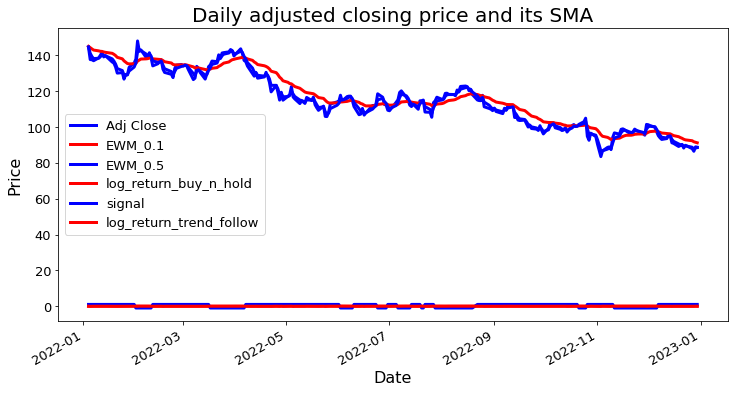

In [16]:
tf.plot_ewma_x()

In [11]:
tf(alpha_1=0.2, alpha_2=0.55)

-2.2009780393309164

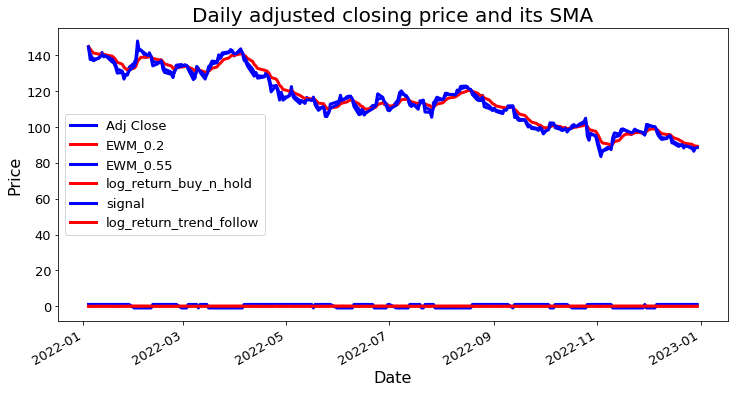

In [13]:
tf.plot_ewma_x()